# 图像自动色阶

PS 给出的定义： 

Enhance Per Channel Contrast：Maximizes the tonal range in each channel to produce a more dramatic correction.Because each channel is adjusted individually, Enhance Per Channel Contrast may remove or introduce color casts.The Auto Levels command uses this algorithm.

简单来说，就是对R，G，B三个通道的动态范围分别进行拉伸。

算法参数 clipping percentage， 默认值是 0.1%。

根据这个定义，可以先写出算法的思路：

假设图像像素值范围为：0-1
$$
if \quad  x < x_{min}:  y=0;
$$
$$
if \quad x > x_{max}:  y=1;
$$
$$
if \quad x_{min} < x < x_{max}:   y=\frac{x-x_{min}}{x_{max}-x_{min}} 
$$

自动色阶可用于去雾，算法比较稳定的，特别是对于雾分布均匀，效果很好；缺点也比较明显，不能自适应雾的分布，且通道分离计算，有些时候会带来一些颜色失真现象。

In [1]:
from skimage import io,color
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def ComputeHist(img):
    h,w = img.shape
    hist, bin_edge = np.histogram(img.flatten(), bins=list(range(257)))
    return hist
    
def ComputeMinLevel(hist, rate, pnum):
    sum = 0
    for i in range(256):
        sum += hist[i]
        if (sum >= (pnum * rate * 0.01)):
            return i
            
def ComputeMaxLevel(hist, rate, pnum):
    sum = 0
    for i in range(256):
        sum += hist[255-i]
        if (sum >= (pnum * rate * 0.01)):
            return 255-i
            
def LinearMap(minlevel, maxlevel):
    if (minlevel >= maxlevel):
        return []
    else:
        newmap = np.zeros(256, dtype=int)
        for i in range(256):
            if (i < minlevel):
                newmap[i] = 0
            elif (i > maxlevel):
                newmap[i] = 255
            else:
                newmap[i] = (int)(float(i-minlevel)/float(maxlevel-minlevel) * 255)
        return newmap
        
def CreateNewImg(img):
    h,w,d = img.shape
    newimg = np.zeros(img.shape,dtype=np.ubyte)
    for i in range(d):
        imghist  = ComputeHist(img[:,:,i])
        minlevel = ComputeMinLevel(imghist, 8.2, h*w)
        maxlevel = ComputeMaxLevel(imghist, 2.2, h*w)
        newmap = LinearMap(minlevel,maxlevel)
        # print(minlevel, maxlevel)
        # print(newmap)
        for m in range(h):
            for n in range(w):
                newimg[m,n,i] = newmap[img[m,n, i]]
    return newimg

(-0.5, 966.5, 999.5, -0.5)

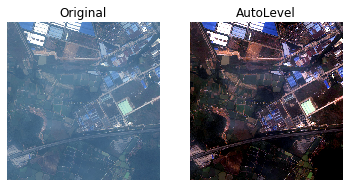

In [3]:
%matplotlib inline
img = io.imread('images/fog.jpg')
dst = CreateNewImg(img)
plt.subplot(121)
plt.imshow(img)
plt.title('Original')
plt.axis('off')
plt.subplot(122)
plt.imshow(dst)
plt.title('AutoLevel')
plt.axis('off')

# 自动对比度
 
  自动对比度与自动色阶的最大区别是：首先根据设定的门限计算出RGB三个通道各自的最大值和最小值，然后从RGB三个通道各自的最大值最小值中挑选出最小值和最大值，以此为基础对图像进行RGB通道的线性拉伸。